### Precalculated Tables
tamara.huete@vizzuality.com - October 2021

The Areas of Interest (AOIs) of the Half Earth Map has 2 sections, one with *on the fly* calculations and another one with *precalculated data*. In this notebook we create separte services for the precalculated data of GADM0, GADM1 and WDPA.  
The data includes: 
+ Biodiversity data (amphibians, reptiles, mammals and birds in each area): This data comes from running the tool Sample inside ArcGis Pro against the bidiversity crfs and needs to be formatted for the FE to read as list of arrays [{},{},{}]. The crfs are projected, therefore the assumption we are making is that **1 pixel = 1km2**.
+ Contextual data (population, climate regime, land cover and land use): Each section comes from a different data source with separate crfs created and then Zonal Stats is applied inside ArcGis Pro. Here we format the data for FE.  
+ Only for GADM0 and GADM1, there is an addittional field that has the list of WDPA's found in that geometry. The list shows the MOL_ID (The WDPA list is deprecated, FE asked to have a separate table, so this is not udes anymore)

Once the FS are in AOL, the style of the FS should be changed to have **outline: #d8d8d8**, **fill: none**

### Table of contents:
* [GADM 1 data](#first-bullet)
* [GADM 0 data](#second-bullet)
* [WDPA data](#third-bullet)

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy

In [2]:
env_path = "../../.env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

In [3]:
aol_password = env['ARCGIS_GRETA_PASS']
aol_username = env['ARCGIS_GRETA_USER']

In [4]:
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")

In [5]:
import re
def create_strict_reg_exp(to_search):
    try:
        reg_exp = f"^{to_search}$"
        #logging.info(f"regular expression is: {reg_exp}")
    except:
        print("There was a problem with the string.")
    return reg_exp

In [6]:
def findItemGetID(csvName, gis, item_type = "Feature Layer"):
    try:
        searched_item = gis.content.search(csvName, item_type = item_type)
        for i in searched_item:
            reg_exp = create_strict_reg_exp(csvName)
            if re.search(reg_exp, i.title)!= None:    
                #logging.info(f"{csvName} has the id: {i.id}")
                return i.id
    except:
        print("There was a problem finding the item")

In [7]:
def getFlayerFromID(item_id):
    item = gis.content.get(item_id)
    flayer = item.layers[0]
    return flayer

In [8]:
import pandas as pd
def getSDFfromFlayer(flayer):
    sdf = pd.DataFrame.spatial.from_layer(flayer)
    return sdf

In [9]:
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.tables[0]
    sdf = flayer.query().sdf
    return sdf

## GADM 1 data <a class="anchor" id="first-bullet"></a>

Original gadm 1 table from Scott: https://eowilson.maps.arcgis.com/home/item.html?id=122082293e614e06bddbe532063accc9  
Same table Simplified: https://eowilson.maps.arcgis.com/home/item.html?id=4afeb2c82e8a45e98f9c698cb2259dc0

In [8]:
## GADM 1 biodiversity ids on ArcGis Online (outputs of Sample tool in ArcGisPro)
layer_ids = {'amph':'30056f994d5748198ffd8f45619692a2',
             'birds':'8663c992ab66475f8b818048725fa98e',
             'mamm':'8f2ad6b4ef8547f79e82c9d98e481922',
             'rept':'e92386ef1f4b423faae3f7afb1330319'}

In [8]:
### gadm tables
## Original scott table
scott= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level1.zip')

## Simplified scott table
gadm = gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level1_Simplify.zip')

### gadm as raster area (from Scotts table)
gadmpix = pd.read_csv('../../HALF_EARTH/gadm1_polygon_to_raster.csv')

In [30]:
gadmpix.head()

,OID_,Value,Count
0,1,1,43697.0
1,2,2,20581.0
2,3,3,21120.0
3,4,4,17265.0
4,5,5,14173.0


In [31]:
gadm = gadm.merge(gadmpix, right_on = 'Value', left_on = 'MOL_ID')
gadm.rename(columns={'Count':'AREA_PX'}, inplace = True)

In [32]:
amph.rename(columns={'SliceNumbe':'SliceNumber','SUM_amphib':'SUM'}, inplace=True)
rept.rename(columns={'SliceNumbe':'SliceNumber','SUM_reptil':'SUM'}, inplace=True)
mam.rename(columns={'SliceNumbe':'SliceNumber','SUM_presen':'SUM'}, inplace=True)
bird.rename(columns={'SliceNumbe':'SliceNumber','SUM_birds':'SUM'}, inplace=True)

In [33]:
amph = amph.merge(gadm[['MOL_ID','AREA_KM2','AREA_PX']])
amph['percentage_presence'] = round(amph['SUM']/amph['AREA_PX']*100,2)

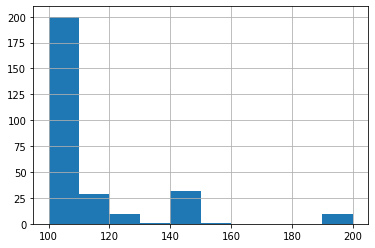

In [245]:
### There are 434 rows that have over 100% of presence
amph.loc[amph['percentage_presence']> 100,'percentage_presence'].hist()

In [36]:
len(amph.loc[amph['percentage_presence']> 100,'percentage_presence'])

281

#### - (GADM1) Format Biodiversity data

In [269]:
### Use here Scott original data because the simplification has deleted some provinces
dff = scott[['GID_0','NAME_0','GID_1','NAME_1','MOL_ID','AREA_KM2','geometry']]
dff['reptiles']=np.nan
dff['amphibians']=np.nan
dff['mammals']=np.nan
dff['birds']=np.nan

paths = {'amphibians':'../../HALF_EARTH/amphibians_gadm1_final_20211003.zip',
         'birds':'../../HALF_EARTH/birds_gadm1_final_20211003.zip',
         'mammals':'../../HALF_EARTH/mammals_gadm1_final_20211003.zip',
         'reptiles':'../../HALF_EARTH/reptiles_gadm1_final_20211003.zip'}

### Ids of lookup tables for each taxa in ArcGIS online
lookups = {'amphibians':'a641a4cd269345dea93b8bcb1cb66676',
         'birds':'4d8698734b654bb9bb7a61d9af314c76',
         'mammals':'84d3c71caf97479d85f620a4ee217d68',
         'reptiles':'b720e84869624e5482b25338b27a54f2'}

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [270]:
%%time
### Loop over each set of data and add all results to one dictionary that will be a text field in the Feature Service
for taxa in paths.keys():
    print(taxa) 
    df = pd.read_csv(paths[taxa])
    col_name = [col for col in df.columns if 'SUM' in col]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)
    
    ### Get species area against global species range:
    lookup = getHTfromId(lookups[taxa])
    df = df.merge(lookup[['SliceNumber','range_area_km2']], how='left',on = 'SliceNumber')
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    
    ### Get species area against aoi area:
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
    
    ### Format as array of dicts:
    for i in dff.MOL_ID:
        species = []
        for j in df[(df.MOL_ID== i)].SliceNumber.unique():
            sp_dict = {'SliceNumber':int(df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0]),
                       'per_global':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_global.values[0],
                       'per_aoi':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_aoi.values[0]
                      }
            species.append(sp_dict)
        dff.loc[dff['MOL_ID']==i,taxa] =json.dumps(species)
    print(f'finished MOL_ID ={i}')
pd.set_option('display.max_colwidth',None)
test= pd.DataFrame(dff[dff.columns[~dff.columns.isin(['geometry'])]])
test.to_csv("../../HALF_EARTH/gadm1_precalc_biodiv_range.csv",index=False)
pd.reset_option('display.max_colwidth')

#### Don't export as shapefile because it truncates the string length

amphibians
finished MOL_ID =3610
birds
finished MOL_ID =3610
mammals
finished MOL_ID =3610
reptiles
finished MOL_ID =3610
CPU times: user 2h 14min 45s, sys: 2min 42s, total: 2h 17min 27s
Wall time: 2h 27min 22s


In [9]:
#dff = pd.read_csv("../../HALF_EARTH/gadm1_precalc_biodiv.csv") # area
dff = pd.read_csv("../../HALF_EARTH/gadm1_precalc_biodiv_range.csv") # species range

In [10]:
dff.loc[dff['MOL_ID']==1,'reptiles'].values[0]

'[{"SliceNumber": 4, "per_global": 1.97, "per_aoi": 0.12}, {"SliceNumber": 9, "per_global": 1.37, "per_aoi": 71.32}, {"SliceNumber": 327, "per_global": 0.25, "per_aoi": 0.03}, {"SliceNumber": 1227, "per_global": 0.07, "per_aoi": 0.27}, {"SliceNumber": 1229, "per_global": 0.64, "per_aoi": 7.49}, {"SliceNumber": 1555, "per_global": 0.0, "per_aoi": 0.17}, {"SliceNumber": 2527, "per_global": 0.36, "per_aoi": 11.62}, {"SliceNumber": 3470, "per_global": 0.06, "per_aoi": 5.37}, {"SliceNumber": 3737, "per_global": 1.1, "per_aoi": 0.92}, {"SliceNumber": 3741, "per_global": 0.31, "per_aoi": 13.08}, {"SliceNumber": 3747, "per_global": 1.4, "per_aoi": 3.32}, {"SliceNumber": 3805, "per_global": 0.0, "per_aoi": 0.1}, {"SliceNumber": 3808, "per_global": 0.11, "per_aoi": 9.19}, {"SliceNumber": 3829, "per_global": 0.81, "per_aoi": 16.62}, {"SliceNumber": 3832, "per_global": 0.2, "per_aoi": 11.19}, {"SliceNumber": 4540, "per_global": 0.5, "per_aoi": 26.08}, {"SliceNumber": 4939, "per_global": 0.01, "per

In [11]:
len(dff)

3610

#### Combine 3 layers layers 
* GEOMETRY: GADM Base layer with simplified geometries and MOL ID ([CSV](https://eowilson.maps.arcgis.com/home/item.html?id=81de5933b1894ac082f50536cf98bf46))
* CONTEXTUAL DATA: Precalculated contextual data ([FS](https://eowilson.maps.arcgis.com/home/item.html?id=8b830df4fbca4a8388a120dfa13d887b) and [CSV](https://eowilson.maps.arcgis.com/home/item.html?id=b733d87f2117412d8ee8c3b684218ce4)) (Also has GADM level 0 and 1, with more countries than the ones provided by MOL)
* BIODIVERSITY DATA: Precalculated biodiversity data (dff)

#### - (GADM1) Format Contextual data

In [12]:
### Contextual data
### Aol layer: https://eowilson.maps.arcgis.com/home/item.html?id=8b830df4fbca4a8388a120dfa13d887b
precalc = pd.read_csv('../../HALF_EARTH/gadm_level0_and_1_Merge.zip')

In [13]:
precalc.columns

Index(['OBJECTID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'VARNAME_1',
       'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'geom_Length',
       'geom_Area', 'country_size', 'country_zoom', 'GID_0_1',
       'percentage_protected', 'percent_irrigated', 'percent_rainfed',
       'percent_rangeland', 'percent_urban', 'population_sum',
       'majority land cover climate regime', 'land_cover_majority',
       'climate_regime_majority', 'Shape__Area', 'Shape__Length'],
      dtype='object')

In [14]:
### Countries in first list that are not in the second list
len(list(set(precalc.GID_0) ^ set(dff.GID_0)))
### There are 28 counties missing from the simplified gadm dataset

28

In [15]:
### Check Scott's original data before simplification
list(set(scott.GID_0) ^ set(dff.GID_0)) ### All countries in both tables

[]

In [16]:
### Join contextual data and precalculated data
dff.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'MOL_ID', 'AREA_KM2', 'reptiles',
       'amphibians', 'mammals', 'birds'],
      dtype='object')

In [17]:
if 'Unnamed: 0' in dff.columns:
    dff.drop(columns='Unnamed: 0',inplace = True)
if 'Unnamed: 0.1' in dff.columns:
    dff.drop(columns='Unnamed: 0.1',inplace = True)

In [18]:
dff_merge = dff.merge(precalc[['percentage_protected', 'percent_irrigated', 'percent_rainfed',
       'percent_rangeland', 'percent_urban', 'population_sum',
       'majority land cover climate regime', 'land_cover_majority',
       'climate_regime_majority','GID_1','country_size']], on ='GID_1',how='left')

In [19]:
dff_merge.rename(columns={'majority land cover climate regime':'majority_land_cover_climate_regime'},inplace=True)

In [20]:
len(dff_merge)

3610

In [21]:
dff_merge.loc[dff_merge['MOL_ID']==1,'reptiles'].values[0]

'[{"SliceNumber": 4, "per_global": 1.97, "per_aoi": 0.12}, {"SliceNumber": 9, "per_global": 1.37, "per_aoi": 71.32}, {"SliceNumber": 327, "per_global": 0.25, "per_aoi": 0.03}, {"SliceNumber": 1227, "per_global": 0.07, "per_aoi": 0.27}, {"SliceNumber": 1229, "per_global": 0.64, "per_aoi": 7.49}, {"SliceNumber": 1555, "per_global": 0.0, "per_aoi": 0.17}, {"SliceNumber": 2527, "per_global": 0.36, "per_aoi": 11.62}, {"SliceNumber": 3470, "per_global": 0.06, "per_aoi": 5.37}, {"SliceNumber": 3737, "per_global": 1.1, "per_aoi": 0.92}, {"SliceNumber": 3741, "per_global": 0.31, "per_aoi": 13.08}, {"SliceNumber": 3747, "per_global": 1.4, "per_aoi": 3.32}, {"SliceNumber": 3805, "per_global": 0.0, "per_aoi": 0.1}, {"SliceNumber": 3808, "per_global": 0.11, "per_aoi": 9.19}, {"SliceNumber": 3829, "per_global": 0.81, "per_aoi": 16.62}, {"SliceNumber": 3832, "per_global": 0.2, "per_aoi": 11.19}, {"SliceNumber": 4540, "per_global": 0.5, "per_aoi": 26.08}, {"SliceNumber": 4939, "per_global": 0.01, "per

In [22]:
### Join with gadm (simplified) geometry
all_data =dff_merge.merge(gadm[['geometry','MOL_ID']],on ='MOL_ID',how='inner')

In [23]:
all_data.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'MOL_ID', 'AREA_KM2', 'reptiles',
       'amphibians', 'mammals', 'birds', 'percentage_protected',
       'percent_irrigated', 'percent_rainfed', 'percent_rangeland',
       'percent_urban', 'population_sum', 'majority_land_cover_climate_regime',
       'land_cover_majority', 'climate_regime_majority', 'country_size',
       'geometry'],
      dtype='object')

In [24]:
gdf = gpd.GeoDataFrame(all_data, geometry=all_data.geometry)
# gdf.to_file('../../HALF_EARTH/all_precalc.geojson',driver='GeoJSON') # area
gdf.to_file('../../HALF_EARTH/gadm1_precalculated_range.geojson',driver='GeoJSON') # range

In [79]:
gdf = gpd.read_file('../../HALF_EARTH/gadm1_precalculated_range.geojson')

In [244]:
### Save full version as geojson
gdf = gpd.GeoDataFrame(all_data, geometry=all_data.geometry)
gdf.to_file('../../HALF_EARTH/gadm1_precalculated_range.geojson',driver='GeoJSON')

### Save geometry with MOL ID as shapefile
# gdf[['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'MOL_ID', 'AREA_KM2','geometry']].to_file('../../HALF_EARTH/gadm1_simple.shp')

### Save porcalculated data without geometry as csv
# all_data[all_data.columns[~all_data.columns.isin(['geometry'])]].to_csv('../../HALF_EARTH/gadm1_precalc_no_geometry.csv')

### Upload all to AGOL through portal

In [151]:
### Failing to upload geojson for the range data
old = gpd.read_file('../../HALF_EARTH/all_precalc.geojson')
dff = pd.read_csv("../../HALF_EARTH/gadm1_precalc_biodiv_range.csv") # species range

In [153]:
#drop biodiv layers from old layer and substitute by the new ones (range)
old = old.drop(columns=['birds']) # for some reason mammals, reptiles and amphibians are not in this table

In [160]:
old_mod = old.merge(dff[['MOL_ID','amphibians','birds','reptiles','mammals']], on = 'MOL_ID')

In [163]:
old_mod.to_file('../../HALF_EARTH/gadm1_precalculated_range2.geojson',driver='GeoJSON')

## Final layer:
### 1. Percentage_presence as portion of geometry area (DEPRECATED):
* Upload everything as geojson: [FS](https://eowilson.maps.arcgis.com/home/item.html?id=3f89b653de41428a8166d51f383f0950)/ [URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/gadm1_precalculated/FeatureServer)/[Whitelisted](https://utility.arcgis.com/usrsvcs/servers/4870a51b17f841c38793b3c0a3f053c9/rest/services/gadm1_precalculated/FeatureServer)
* Upload 2 layers: [gadm simplified FS](https://eowilson.maps.arcgis.com/home/item.html?id=a3a2cf24f3b549c2b16f82bd996f7d16)/[URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/gadm1_simple_geometry/FeatureServer) and [precalculated data FS](https://eowilson.maps.arcgis.com/home/item.html?id=c6f8cbcbcfe54a4abab3da33a7226bcd)/[URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/gadm1_precalc_no_geometry/FeatureServer)/[Whitelisted](https://utility.arcgis.com/usrsvcs/servers/d9732336623740eda16d15322d2f14a2/rest/services/gadm1_precalc_no_geometry/FeatureServer) and join in the FE by GID_1 or MOL_ID

### 2. Percentage_presence as portion of global species area (DEPRECATED):
* Upload everything as geojson: [FS](https://eowilson.maps.arcgis.com/home/item.html?id=04be557b601d4f0a951aef3d90d917dc)/ [URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/gadm1_precalculated_range/FeatureServer)/[Whitelisted](https://utility.arcgis.com/usrsvcs/servers/56f6738878394ccf9ec258af1275bdaa/rest/services/gadm1_precalculated_range/FeatureServer)

### 3. Both per_aoi and per_global (IN USE):
* Upload everything as geojson: [FS](https://eowilson.maps.arcgis.com/home/item.html?id=04be557b601d4f0a951aef3d90d917dc)/ [URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/gadm1_precalculated_range/FeatureServer)/[Whitelisted](https://utility.arcgis.com/usrsvcs/servers/329a41aec90249c2ba5d6330f43f9390/rest/services/gadm1_precalculated_range_area/FeatureServer)

#### (GADM1) WDPA table by country

In [2]:
## Add list of wdpa's per country
## gadm1 (scott's original)
gadm1= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level1.zip')
## wdpa (scott's original)
wdpa= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.zip')

In [7]:
gadm = gadm1[['GID_0','NAME_1','MOL_ID','geometry']]
gadm.rename(columns={'MOL_ID':'MOL_IDg'},inplace=True)
wd = wdpa[['MOL_ID','ISO3','geometry']]

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
gwd = gpd.sjoin(gadm,wd)

In [44]:
gadm1['WDPA_MOL_ID']=gadm1['MOL_ID'].apply(lambda x: gwd[gwd['MOL_IDg']==x].MOL_ID.unique())

In [ ]:
gwd[gwd['MOL_IDg']==1].MOL_ID.unique()

In [53]:
gadm1.head(3)

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,AREA_KM2,MOL_ID,geometry,WDPA_MOL_ID
0,AFG,Afghanistan,AFG.1_1,Badakhshan,Badah?an,None,Velayat,Province,None,AF.BD,43692.210235,1,"POLYGON ((71.14804 36.00124, 71.14226 35.99334...","[50863, 47366, 62082, 47365, 62076, 206425, 21..."
1,AFG,Afghanistan,AFG.2_1,Badghis,Badghes|Badghisat|Badgis,None,Velayat,Province,None,AF.BG,20589.857163,2,"POLYGON ((63.09734 34.64551, 63.08250 34.65775...",[]
2,AFG,Afghanistan,AFG.3_1,Baghlan,Baglan|Bughlan,None,Velayat,Province,None,AF.BL,21120.261382,3,"POLYGON ((67.35538 34.88549, 67.35532 34.88847...","[175193, 216112]"


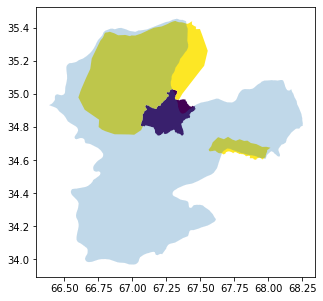

In [54]:
import matplotlib.pyplot as plt
### test that the spatial join worked
n=5
wd_list = list(gwd[gwd['MOL_IDg']==n].MOL_ID.unique())
fig, ax = plt.subplots(figsize=(5, 5))
wd[wd['MOL_ID'].isin(wd_list)].plot(ax=ax, column='MOL_ID')
gwd[gwd['MOL_IDg']==n].plot(ax=ax,alpha=0.1)

### Publish GADM Simplified layer as FS using the python API

In [146]:
def publishCSVasFS(csv_file,csvName, gis, aol_folder_name, sharing, table): # sharing = 'None', 'groups', 'everyone' # table = yes, no
    try:
        
        if gis.content.is_service_name_available(csvName, "featureService"):
            print(f"Service name {csvName} is available")
            #csv_file = f'./{csvName}.csv'
            csv_item = gis.content.add({}, csv_file)
            #csv_lyr = csv_item.publish(None,  {'CountryCode' : 'countryname'})
            if table == 'yes':
                csv_lyr = csv_item.publish(publish_parameters={'locationType':'none', 'type':'csv'})
            else:
                csv_lyr = csv_item.publish()
                flayer_collection = FeatureLayerCollection.fromitem(csv_lyr)
                searched_flayer = flayer_collection.layers[0] 
                nber_features = searched_flayer.query(return_count_only=True)
                print(f"The service {csvName} has been published. The service has {nber_features} entries")
            print(f"Moving service {csvName} to {aol_folder_name} in ArcGIS Online...")
            # move both the csv_item and csv_lyr items into this new folder
            csv_item.move(aol_folder_name)
            csv_lyr.move(aol_folder_name)
            print(f"Service {csvName} has been moved to {aol_folder_name} in ArcGIS Online")
#             sharing, default is owner
#             csv_lyr.shared_with
            if sharing == 'None':
                csv_lyr.share(everyone=False, org=False, groups=None, allow_members_to_edit=False)
            if sharing == 'groups':
            # the group id is needed to share with agroup
                csv_lyr.share(everyone=False, org=False, groups=[group_id], allow_members_to_edit=False)
            if sharing == 'everyone':
                csv_lyr.share(everyone=True, org=False, groups=None, allow_members_to_edit=False)
            sharing_prop = csv_lyr.shared_with
            if sharing_prop['everyone']==True:
                print(f"shared with everyone")   
            else:
                print(f"not a public layer, for this layer to be used it has to be public or the urls have to be whitelisted")            
            #not allowing deleting
            csv_lyr.protect()
            print(f"{csvName}'s protection against deletion : {csv_lyr.protected}") 
            # it is possible to check the status with csv_item.content_status
            return csv_lyr.id
        else:
            print("The service name is not available, try overwritting, appending the data or a different service name")
    except:
        print("The csv hasn't been published")

In [189]:
# The file we want to add
csv_file = '../../HALF_EARTH/gadm36_level1_simple_precalc.zip'
csvName = 'gadm36_level1_simple_precalc'
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")
aol_folder_name = '#6 precalculated data'
group_id='46783c33c294485abe83f5e899c2f21f'
publishCSVasFS(csv_file,csvName,gis,aol_folder_name,sharing='groups')

Service name gadm36_level1_simple_precalc is available
The service gadm36_level1_simple_precalc has been published. The service has 3610 entries
Moving service gadm36_level1_simple_precalc to #6 precalculated data in ArcGIS Online...
Service gadm36_level1_simple_precalc has been moved to #6 precalculated data in ArcGIS Online
not a public layer, for this layer to be used it has to be public or the urls have to be whitelisted
gadm36_level1_simple_precalc's protection against deletion : True


'b162f17e7b254312bf35e3197c9b1f08'

### Update the field wdpa_mol_id field in the existing feature service with python API 

In [92]:
item = gis.content.get('3f89b653de41428a8166d51f383f0950')
flayer = item.layers[0]
sdf = pd.DataFrame.spatial.from_layer(flayer)

#### Create new fields on FS and update with the values of the new dataframe

In [38]:
## Create fields
def createFieldsToBeAdded(flayer, csv_table):
    flayer_fields = flayer.manager.properties.fields
    template_field = dict(deepcopy(flayer_fields[0]))
    sdf = getSDFfromFlayer(flayer)
    new_field_names = list(csv_table.columns.difference(sdf.columns))
    
    fields_to_be_added = []
    for new_field_name in new_field_names:
        current_field = deepcopy(template_field)
        dt = csv_table[new_field_name].dtypes
        
        if dt == 'O':
            #put the type to character
            current_field['sqlType'] = 'sqlTypeOther'
            current_field['type'] = 'esriFieldTypeString'
            current_field['length'] = 45000
        if dt == 'float64':
            #put the type to double
            current_field['sqlType'] = 'sqlTypeOther'
            current_field['type'] = 'esriFieldTypeDouble'
            #current_field['length'] = 8000      

        current_field['name'] = new_field_name.lower()
        current_field['alias'] = new_field_name
        current_field['nullable'] = True
        current_field['editable'] = True
        fields_to_be_added.append(current_field)
    return fields_to_be_added

In [45]:
#https://developers.arcgis.com/python/sample-notebooks/updating-features-in-a-feature-layer/
def createFeaturesForUpdate(flayer, csv_table, fields_to_be_added, id_field_in_csv, id_field_in_service):
    fset2 = flayer.query()
    features2 = fset2.features
    features_for_update = []
    for country_id in csv_table[id_field_in_csv]:
        try:
            # get the matching row from csv
            matching_row = csv_table.where(csv_table[id_field_in_csv] == country_id).dropna()

            #print(str(country_id) + " Adding additional attributes for: " + matching_row['iso3'].values[0])

            # get the feature to be updated
            assert  len([f for f in features2 if f.attributes[id_field_in_service] == country_id]),  "id not matched"
            original_feature = [f for f in features2 if f.attributes[id_field_in_service] == country_id][0]
            feature_to_be_updated = deepcopy(original_feature)

            # assign the updated values
            for field in fields_to_be_added:
                #feature_to_be_updated.attributes[field['name']] = matching_row[field['name']].values[0]
                ### this line creates a string of the list (important that the type matches the data type created with createFieldsToBeAdded)
                feature_to_be_updated.attributes[field['name']] = str(list(matching_row[field['name']].values[0]))
                #add this to the list of features to be updated
                features_for_update.append(feature_to_be_updated)
            #print(str(country_id) + " Done additional attributes for: " + matching_row['countryname'].values[0])
    
        except:
            print(f"{country_id} not available in service")
    return features_for_update

#### add only wdpa_mol_id

In [82]:
gadm1.rename(columns={'WDPA_MOL_ID':'wdpa_mol_id'},inplace=True)

In [114]:
fields_to_be_added = createFieldsToBeAdded(flayer, csv_table= gadm1[['MOL_ID','wdpa_mol_id']])

In [115]:
fields_to_be_added

[{'name': 'wdpa_mol_id',
  'type': 'esriFieldTypeString',
  'actualType': 'nvarchar',
  'alias': 'wdpa_mol_id',
  'sqlType': 'sqlTypeOther',
  'length': 45000,
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None}]

In [151]:
flayer.manager.add_to_definition({'fields':fields_to_be_added})

{'success': True}

In [ ]:
#### Updates must be done in blocks of 100 to avoid broken pipe of ARcGIS API

In [154]:
start = np.arange(0,3160, step = 100)
start

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100])

In [163]:
# Broken Pipe, the connection times out so it has to be broken down to less updates (chunks of 100)
for i in start:
    features_for_update = createFeaturesForUpdate(flayer,  
                                              gadm1[['MOL_ID','wdpa_mol_id']][i:i+100], 
                                              fields_to_be_added, 
                                              id_field_in_csv = "MOL_ID", 
                                              id_field_in_service = "MOL_ID")
    flayer.edit_features(updates= features_for_update)
    print(f'done {i}')
    

done 0
done 100
done 200
done 300
done 400
done 500
done 600
done 700
done 800
done 900
done 1000
done 1100
done 1200
done 1300
done 1400
done 1500
done 1600
done 1700
done 1800
done 1900
done 2000
done 2100
done 2200
done 2300
done 2400
done 2500
done 2600
done 2700
done 2800
done 2900
done 3000
done 3100


In [ ]:
#https://www.esri.com/arcgis-blog/products/arcgis-desktop/mapping/how-to-extend-attribute-table-field-size-from-255-characters/

## GADM level 0 <a class="anchor" id="second-bullet"></a>

In [ ]:
## GADM 0 biodiversity ids on ArcGis Online
layer_ids = {'amph':'cd6f092a158b4beb8388207d0aa55e55',
             'birds':'d9ed800d4fd94545bb87e716c4027189',
             'mamm':'54fd6a5392c3438f96fabfbcd15a39f0',
             'rept':'15822b0b6b784d0184d8bddd9c16730f'}

In [13]:
### gadm tables
## Original scott table
scott= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level0.zip')

## Simplified scott table
### Douglas Pickler 0.005º simplification
gadm = gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level0_original_simple.zip')

#### - (GADM0) Format Biodiversity data

In [199]:
### Use here simple gadm0 
dff = gadm[['GID_0','NAME_0','MOL_ID','AREA_KM2','geometry']]
dff['reptiles']=np.nan
dff['amphibians']=np.nan
dff['mammals']=np.nan
dff['birds']=np.nan

paths = {'amphibians':'../../HALF_EARTH/gadm0_amphibians_final_2021.zip',
         'birds':'../../HALF_EARTH/gadm0_birds_sample_20211003_.zip',
         'mammals':'../../HALF_EARTH/gadm0_mammals_final_2021100.zip',
         'reptiles':'../../HALF_EARTH/gadm0_reptiles_final_202110.zip'}

### Ids of lookup tables for each taxa in ArcGIS online
lookups = {'amphibians':'a641a4cd269345dea93b8bcb1cb66676',
         'birds':'4d8698734b654bb9bb7a61d9af314c76',
         'mammals':'84d3c71caf97479d85f620a4ee217d68',
         'reptiles':'b720e84869624e5482b25338b27a54f2'}

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [207]:
%%time
### Loop over each set of data and add all results to one dictionary that will be a text field in the Feature Service
for taxa in paths.keys():
    print(taxa) 
    df = pd.read_csv(paths[taxa])
    col_name = [col for col in df.columns if 'SUM' in col]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)
    
    ### Get species area against global species range:
    lookup = getHTfromId(lookups[taxa])
    df = df.merge(lookup[['SliceNumber','range_area_km2']], how='left',on = 'SliceNumber')
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    
    ### Get species area against aoi area:
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
    
    ### Format as array of dicts:
    for i in dff.MOL_ID:
        species = []
        for j in df[(df.MOL_ID== i)].SliceNumber.unique():
            sp_dict = {'SliceNumber':int(df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0]),
                       'per_global':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_global.values[0],
                       'per_aoi':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_aoi.values[0]
                      }
            species.append(sp_dict)
        dff.loc[dff['MOL_ID']==i,taxa] =json.dumps(species)
    print(f'finished MOL_ID ={i}')
pd.set_option('display.max_colwidth',None)
test= pd.DataFrame(dff[dff.columns[~dff.columns.isin(['geometry'])]])
test.to_csv("../../HALF_EARTH/gadm0_precalc_biodiv_range_area.csv",index=False)
pd.reset_option('display.max_colwidth')

#### Don't export as shapefile because it truncates the string length

amphibians
finished MOL_ID =255
birds
finished MOL_ID =255
mammals
finished MOL_ID =255
reptiles
finished MOL_ID =255
CPU times: user 5min 31s, sys: 3.82 s, total: 5min 35s
Wall time: 6min 6s


In [10]:
dff = pd.read_csv("../../HALF_EARTH/gadm0_precalc_biodiv_range_area.csv")

In [11]:
dff.loc[dff['MOL_ID']==1,'reptiles'].values[0]

'[{"SliceNumber": 353, "per_global": 0.01, "per_aoi": 90.14}, {"SliceNumber": 826, "per_global": 34.44, "per_aoi": 68.15}, {"SliceNumber": 1521, "per_global": 0.01, "per_aoi": 67.61}, {"SliceNumber": 2135, "per_global": 0.0, "per_aoi": 54.41}, {"SliceNumber": 2147, "per_global": 0.0, "per_aoi": 54.41}, {"SliceNumber": 2222, "per_global": 0.0, "per_aoi": 26.38}, {"SliceNumber": 2344, "per_global": 91.95, "per_aoi": 87.94}, {"SliceNumber": 2349, "per_global": 0.0, "per_aoi": 64.31}, {"SliceNumber": 2352, "per_global": 12.0, "per_aoi": 8.24}, {"SliceNumber": 2400, "per_global": 0.0, "per_aoi": 67.61}, {"SliceNumber": 2475, "per_global": 0.0, "per_aoi": 2.75}, {"SliceNumber": 2516, "per_global": 0.01, "per_aoi": 23.63}, {"SliceNumber": 3428, "per_global": 0.0, "per_aoi": 35.18}, {"SliceNumber": 4187, "per_global": 0.03, "per_aoi": 30.23}, {"SliceNumber": 4695, "per_global": 0.0, "per_aoi": 30.78}, {"SliceNumber": 4697, "per_global": 0.0, "per_aoi": 35.18}, {"SliceNumber": 5073, "per_global

In [12]:
len(dff)

255

### Combine 3 layers 
* GEOMETRY: GADM Base layer with simplified geometries and MOL ID ([CSV](https://eowilson.maps.arcgis.com/home/item.html?id=81de5933b1894ac082f50536cf98bf46))
* CONTEXTUAL DATA: Precalculated contextual data ([FS](https://eowilson.maps.arcgis.com/home/item.html?id=8b830df4fbca4a8388a120dfa13d887b) and [CSV](https://eowilson.maps.arcgis.com/home/item.html?id=b733d87f2117412d8ee8c3b684218ce4)) (Also has GADM level 0 and 1, with more countries than the ones provided by MOL)
* BIODIVERSITY DATA: Precalculated biodiversity data (dff)

In [14]:
### Contextual data
precalc = pd.read_csv('../../HALF_EARTH/gadm_level0_and_1_Merge.zip')

In [15]:
precalc.columns

Index(['OBJECTID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'VARNAME_1',
       'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'geom_Length',
       'geom_Area', 'country_size', 'country_zoom', 'GID_0_1',
       'percentage_protected', 'percent_irrigated', 'percent_rainfed',
       'percent_rangeland', 'percent_urban', 'population_sum',
       'majority land cover climate regime', 'land_cover_majority',
       'climate_regime_majority', 'Shape__Area', 'Shape__Length'],
      dtype='object')

In [16]:
### Countries in first list that are not in the second list
len(list(set(precalc.GID_0) ^ set(dff.GID_0)))
### There is 1 counties missing from the simplified gadm dataset

1

In [ ]:
### Check Scott's original data before simplification
list(set(scott.GID_0) ^ set(dff.GID_0)) ### All countries in both tables

In [12]:
### Join contextual data and precalculated data
dff.columns

Index(['GID_0', 'NAME_0', 'MOL_ID', 'AREA_KM2', 'reptiles', 'amphibians',
       'mammals', 'birds'],
      dtype='object')

In [17]:
if 'Unnamed: 0' in dff.columns:
    dff.drop(columns='Unnamed: 0',inplace = True)
if 'Unnamed: 0.1' in dff.columns:
    dff.drop(columns='Unnamed: 0.1',inplace = True)

In [18]:
gid0 = precalc.loc[pd.isna(precalc["GID_1"]), :]

In [19]:
dff_merge = dff.merge(gid0[['percentage_protected', 'percent_irrigated', 'percent_rainfed',
       'percent_rangeland', 'percent_urban', 'population_sum',
       'majority land cover climate regime', 'land_cover_majority',
       'climate_regime_majority','GID_0','country_size']], on ='GID_0',how='left')

In [20]:
dff_merge.rename(columns={'majority land cover climate regime':'majority_land_cover_climate_regime'},inplace=True)

In [21]:
len(dff_merge)

255

In [22]:
dff_merge.loc[dff_merge['MOL_ID']==1,'reptiles'].values[0]

'[{"SliceNumber": 353, "per_global": 0.01, "per_aoi": 90.14}, {"SliceNumber": 826, "per_global": 34.44, "per_aoi": 68.15}, {"SliceNumber": 1521, "per_global": 0.01, "per_aoi": 67.61}, {"SliceNumber": 2135, "per_global": 0.0, "per_aoi": 54.41}, {"SliceNumber": 2147, "per_global": 0.0, "per_aoi": 54.41}, {"SliceNumber": 2222, "per_global": 0.0, "per_aoi": 26.38}, {"SliceNumber": 2344, "per_global": 91.95, "per_aoi": 87.94}, {"SliceNumber": 2349, "per_global": 0.0, "per_aoi": 64.31}, {"SliceNumber": 2352, "per_global": 12.0, "per_aoi": 8.24}, {"SliceNumber": 2400, "per_global": 0.0, "per_aoi": 67.61}, {"SliceNumber": 2475, "per_global": 0.0, "per_aoi": 2.75}, {"SliceNumber": 2516, "per_global": 0.01, "per_aoi": 23.63}, {"SliceNumber": 3428, "per_global": 0.0, "per_aoi": 35.18}, {"SliceNumber": 4187, "per_global": 0.03, "per_aoi": 30.23}, {"SliceNumber": 4695, "per_global": 0.0, "per_aoi": 30.78}, {"SliceNumber": 4697, "per_global": 0.0, "per_aoi": 35.18}, {"SliceNumber": 5073, "per_global

In [23]:
#gadm0 encorachment looks bad. I rerun the calculations in ArcGIS Pro in this file
hm = pd.read_csv('../../HALF_EARTH/gadm0_encroachment.csv')

In [24]:
hm.head()

,OID_,GID_0,COUNT,SliceNumber,Count_1,percenatge
0,1,AFG,58543.0,1.0,903627.0,6.48
1,2,AGO,976.0,1.0,1494905.0,0.07
2,3,ALB,9493.0,1.0,44392.0,21.38
3,4,ARE,1240.0,1.0,90951.0,1.36
4,5,ARG,19464.0,1.0,4007226.0,0.49


In [25]:
long =hm[['GID_0','SliceNumber','percenatge']].pivot(index='GID_0', columns='SliceNumber', values='percenatge').reset_index().rename(columns=
                                                                                                                              {1.0:'percent_irrigated',
                                                                                                                              2.0:'percent_rainfed',
                                                                                                                              3.0:'percent_rangeland',
                                                                                                                              4.0:'percent_urban'})

In [26]:
long.head()

SliceNumber,GID_0,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban
0,ABW,NaN,24.66,NaN,6.39
1,AFG,6.48,18.49,62.15,0.07
2,AGO,0.07,4.19,67.89,0.08
3,ALA,NaN,50.27,NaN,NaN
4,ALB,21.38,48.75,7.21,1.92


In [27]:
long['sum']=long.iloc[:, 1:5].sum(axis=1)

In [28]:
long[long['sum']>100] ## no cases above 100%

SliceNumber,GID_0,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,sum


In [29]:
### delete columns from dff_merge
dff_merge.drop(columns=['percent_irrigated', 'percent_rainfed', 'percent_rangeland',
       'percent_urban'],inplace=True)

In [30]:
### Join dff_merge with new human encroachment data
all_data =dff_merge.merge(long[['GID_0','percent_irrigated', 'percent_rainfed', 'percent_rangeland',
       'percent_urban']],on ='GID_0',how='left')

In [31]:
len(all_data)

255

In [32]:
len(list(set(all_data.GID_0) ^ set(long.GID_0))) ### countries with no human encroachment?? Christmas island, Marshall islands,Tuvalu,Buvet island...

40

In [33]:
all_data.columns

Index(['GID_0', 'NAME_0', 'MOL_ID', 'AREA_KM2', 'reptiles', 'amphibians',
       'mammals', 'birds', 'percentage_protected', 'population_sum',
       'majority_land_cover_climate_regime', 'land_cover_majority',
       'climate_regime_majority', 'country_size', 'percent_irrigated',
       'percent_rainfed', 'percent_rangeland', 'percent_urban'],
      dtype='object')

In [34]:
### Join with gadm (simplified) geometry
all_data =all_data.merge(gadm[['geometry','MOL_ID']],on ='MOL_ID',how='inner')

In [35]:
#all_data.drop(columns=['geometry_x','geometry_y'],inplace=True)

In [36]:
all_data.head()

,GID_0,NAME_0,MOL_ID,AREA_KM2,reptiles,amphibians,mammals,birds,percentage_protected,population_sum,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,country_size,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,geometry
0,ABW,Aruba,1,1.819384e+02,"[{""SliceNumber"": 353, ""per_global"": 0.01, ""per...","[{""SliceNumber"": 1819, ""per_global"": 0.6, ""per...","[{""SliceNumber"": 329, ""per_global"": 0.0, ""per_...","[{""SliceNumber"": 142, ""per_global"": 0.0, ""per_...",20.609302,1.156561e+05,335.0,Shrubland,Tropical Dry,5,NaN,24.66,NaN,6.39,"POLYGON ((-69.97820 12.46986, -70.02847 12.503..."
1,AFG,Afghanistan,2,6.438575e+05,"[{""SliceNumber"": 1, ""per_global"": 28.71, ""per_...","[{""SliceNumber"": 32, ""per_global"": 100.0, ""per...","[{""SliceNumber"": 167, ""per_global"": 11.15, ""pe...","[{""SliceNumber"": 26, ""per_global"": 1.44, ""per_...",3.785337,3.038970e+07,142.0,Grassland,Cool Temperate Dry,3,6.48,18.49,62.15,0.07,"POLYGON ((68.52644 31.75435, 68.53852 31.75457..."
2,AGO,Angola,3,1.247422e+06,"[{""SliceNumber"": 40, ""per_global"": 26.68, ""per...","[{""SliceNumber"": 2, ""per_global"": 0.59, ""per_a...","[{""SliceNumber"": 28, ""per_global"": 2.22, ""per_...","[{""SliceNumber"": 26, ""per_global"": 4.67, ""per_...",6.679349,3.607495e+07,268.0,Forest,Sub Tropical Moist,2,0.07,4.19,67.89,0.08,"MULTIPOLYGON (((11.73347 -16.67255, 11.74014 -..."
3,AIA,Anguilla,4,8.330331e+01,"[{""SliceNumber"": 316, ""per_global"": 25.32, ""pe...","[{""SliceNumber"": 1819, ""per_global"": 0.23, ""pe...","[{""SliceNumber"": 329, ""per_global"": 0.0, ""per_...","[{""SliceNumber"": 142, ""per_global"": 0.0, ""per_...",2.880000,1.360196e+04,393.0,Grassland,Tropical Moist,5,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-63.42375 18.58903, -63.42847 ..."
4,ALA,Åland,5,1.506261e+03,"[{""SliceNumber"": 2500, ""per_global"": 0.01, ""pe...","[{""SliceNumber"": 963, ""per_global"": 0.01, ""per...","[{""SliceNumber"": 129, ""per_global"": 0.01, ""per...","[{""SliceNumber"": 116, ""per_global"": 0.01, ""per...",1.449518,2.915896e+04,111.0,Forest,Cool Temperate Moist,5,NaN,50.27,NaN,NaN,"MULTIPOLYGON (((21.32195 59.74986, 21.32472 59..."


In [32]:
### Save full version as geojson
gdf = gpd.GeoDataFrame(all_data, geometry=all_data.geometry)
#gdf.to_file('../../HALF_EARTH/all_precalc_gadm0.geojson',driver='GeoJSON') ### area
gdf.to_file('../../HALF_EARTH/gadm0_precalculated_range.geojson',driver='GeoJSON')

### Save geometry with MOL ID as shapefile
### gdf[['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'MOL_ID', 'AREA_KM2','geometry']].to_file('../../HALF_EARTH/gadm1_simple.shp')

### Save precalculated data without geometry as csv
###all_data[all_data.columns[~all_data.columns.isin(['geometry'])]].to_csv('../../HALF_EARTH/gadm0_precalc_no_geometry.csv')

### Upload all to AGOL through portal

## Final solution:
* Upload everything as geojson AREA: [FS](https://eowilson.maps.arcgis.com/home/item.html?id=e9b2595e8ee2406b981fd7c00f77df9c)/ [URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/all_precalc_gadm0/FeatureServer)/[Whitelisted URL] (DEPRECATED)(https://utility.arcgis.com/usrsvcs/servers/ec84dbba085342e081dd44b5f94bc398/rest/services/all_precalc_gadm0/FeatureServer)
* Upload everything as geojson RANGE: [FS](https://eowilson.maps.arcgis.com/home/item.html?id=15485a02800a49eba7855b3b79f1d8be)/[Whitelisted](https://utility.arcgis.com/usrsvcs/servers/348e04300dcb4339a25c44b0e54561b1/rest/services/gadm0_precalculated_range/FeatureServer) (DEPRECATED)

* Upload RANGE + AREA (IN USE)
[FS](https://eowilson.maps.arcgis.com/home/item.html?id=349b82ad2dc04ee7975c550af9896993#overview)
/[Whitelisted](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/gadm0_precalculated_range_area/FeatureServer)

### Update human encroachment fields to Range + Area table (API)

In [37]:
item = gis.content.get('349b82ad2dc04ee7975c550af9896993')
flayer = item.layers[0]
sdf = pd.DataFrame.spatial.from_layer(flayer)

In [41]:
fields_to_be_added = createFieldsToBeAdded(flayer, csv_table= all_data[['MOL_ID','percent_irrigated', 'percent_rainfed', 'percent_rangeland','percent_urban']])

In [42]:
fields_to_be_added

[{'name': 'percent_irrigated',
  'type': 'esriFieldTypeDouble',
  'actualType': 'nvarchar',
  'alias': 'percent_irrigated',
  'sqlType': 'sqlTypeOther',
  'length': 4000,
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None},
 {'name': 'percent_rainfed',
  'type': 'esriFieldTypeDouble',
  'actualType': 'nvarchar',
  'alias': 'percent_rainfed',
  'sqlType': 'sqlTypeOther',
  'length': 4000,
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None},
 {'name': 'percent_rangeland',
  'type': 'esriFieldTypeDouble',
  'actualType': 'nvarchar',
  'alias': 'percent_rangeland',
  'sqlType': 'sqlTypeOther',
  'length': 4000,
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None},
 {'name': 'percent_urban',
  'type': 'esriFieldTypeDouble',
  'actualType': 'nvarchar',
  'alias': 'percent_urban',
  'sqlType': 'sqlTypeOther',
  'length': 4000,
  'nullable': True,
  

In [43]:
flayer.manager.add_to_definition({'fields':fields_to_be_added})

{'success': True}

In [115]:
features_for_update = []

In [44]:
### MODIFIED SCRIPT: For string and data that has NaN in the columns to update ()

def createFeaturesForUpdate(flayer, csv_table, fields_to_be_added, id_field_in_csv, id_field_in_service):
    fset2 = flayer.query()
    features2 = fset2.features
    features_for_update = []
    for country_id in csv_table[id_field_in_csv]:
        try:
            # get the matching row from csv
            matching_row = csv_table.where(csv_table[id_field_in_csv] == country_id).dropna(subset=[id_field_in_csv])

            #print(str(country_id) + " Adding additional attributes for: " + matching_row['iso3'].values[0])

            # get the feature to be updated
            assert  len([f for f in features2 if f.attributes[id_field_in_service] == country_id]),  "id not matched"
            original_feature = [f for f in features2 if f.attributes[id_field_in_service] == country_id][0]
            feature_to_be_updated = deepcopy(original_feature)

            # assign the updated values
            for field in fields_to_be_added:
                feature_to_be_updated.attributes[field['name']] = matching_row[field['name']].values[0]
                #add this to the list of features to be updated
                features_for_update.append(feature_to_be_updated)
            #print(str(country_id) + " Done additional attributes for: " + matching_row['countryname'].values[0])
    
        except:
            print(f"{country_id} not available in service")
    return features_for_update

In [45]:
features_for_update = createFeaturesForUpdate(flayer,  
                                              all_data[['MOL_ID','percent_irrigated', 'percent_rainfed', 'percent_rangeland','percent_urban']], 
                                              fields_to_be_added, 
                                              id_field_in_csv = "MOL_ID", 
                                              id_field_in_service = "MOL_ID")

In [ ]:
features_for_update[0]

In [54]:
#### Updates must be done in blocks to avoid broken pipe of ARcGIS API
start = np.arange(0,1020, step = 10)
start

array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010])

In [58]:
for attempt in range(10):
        try:
            flayer.edit_features(updates= features_for_update[140:150])
        except Exception:
            print(f'Timeout #{attempt}')
            pass

In [ ]:
for i in start:
    for attempt in range(10):
        try:
            flayer.edit_features(updates= features_for_update[i:i+10])
        except Exception:
            print(f'Timeout #{attempt}')
            pass
    print(f'done {i}')

### Add list of wdpa's per country (Deprecated, instead of adding list of mol_ids now there is a separtae table 'wdpa_with_gadm0')

In [5]:
## Add list of wdpa's per country
## gadm1 (scott's original)
gadm0= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/gadm36_level0.zip')
## wdpa (scott's original)
wdpa= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.zip')

In [18]:
gadm0.head()

,GID_0,NAME_0,AREA_KM2,MOL_ID,geometry
0,ABW,Aruba,1.819384e+02,1,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,Afghanistan,6.438575e+05,2,"POLYGON ((68.52644 31.75435, 68.53852 31.75457..."
2,AGO,Angola,1.247422e+06,3,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,Anguilla,8.330331e+01,4,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,Åland,1.506261e+03,5,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


In [ ]:
gadm

In [6]:
gadm = gadm0[['GID_0','NAME_0','MOL_ID','geometry']]
gadm.rename(columns={'MOL_ID':'MOL_IDg'},inplace=True)
#wd = wdpa[['MOL_ID','ISO3','geometry']]
wd = wdpa[['WDPAID','MOL_ID','NAME','ORIG_NA','GOV_TYP','DESIG','DESIG_E','DESIG_T','STATUS','IUCN_CA','ISO3','AREA_KM','geometry']]

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
gwd = gpd.sjoin(gadm,wd, how= 'right')

In [24]:
gwd.head()

,index_left,GID_0,NAME_0,MOL_IDg,WDPAID,MOL_ID,NAME,ORIG_NA,GOV_TYP,DESIG,DESIG_E,DESIG_T,STATUS,IUCN_CA,ISO3,AREA_KM,geometry
57173,0.0,ABW,Aruba,1.0,14067.0,57174,Het Spaans Lagoen,Het Spaans Lagoen,Not Reported,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Designated,Not Reported,ABW,0.099586,"POLYGON ((-69.97523 12.47379, -69.97538 12.474..."
115580,0.0,ABW,Aruba,1.0,555624439.0,115581,Arikok National Park,Arikok National Park,Non-profit organisations,National Park,National Park,National,Designated,Not Reported,ABW,34.964103,"MULTIPOLYGON (((-69.96302 12.48384, -69.96295 ..."
90,0.0,ABW,Aruba,1.0,14003.0,91,Bubali Pond Bird Sanctuary,Bubali Pond Bird Sanctuary,Not Reported,Bird Sanctuary,Bird Sanctuary,National,Designated,Not Reported,ABW,0.578906,"POLYGON ((-70.04734 12.56329, -70.04615 12.563..."
50862,1.0,AFG,Afghanistan,2.0,6820.0,50863,Kilik/Mintaka,Kilik/Mintaka,Not Reported,Game Reserve,Game Reserve,National,Designated,Not Reported,PAK,503.484085,"POLYGON ((74.74915 37.02663, 74.76635 37.02623..."
50862,43.0,CHN,China,44.0,6820.0,50863,Kilik/Mintaka,Kilik/Mintaka,Not Reported,Game Reserve,Game Reserve,National,Designated,Not Reported,PAK,503.484085,"POLYGON ((74.74915 37.02663, 74.76635 37.02623..."


In [25]:
gwd = gwd.drop(columns = ['index_left'])

In [10]:
gwd[gwd['GID_0']=='AFG'].count()[0]

18

In [11]:
wd[wd['ISO3']=='AFG'].count()[0]

9

In [12]:
len(gwd[gwd['MOL_IDg']==70])

3667

In [15]:
len(gwd)

221969

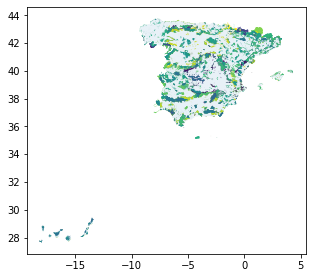

In [28]:
import matplotlib.pyplot as plt
### test that the spatial join worked
n=70
wd_list = list(gwd[gwd['MOL_IDg']==n].MOL_ID.unique())
fig, ax = plt.subplots(figsize=(5, 5))
gwd[gwd['MOL_ID'].isin(wd_list)].plot(ax=ax, column='MOL_ID')
gadm[gadm['MOL_IDg']==n].plot(ax=ax,alpha=0.1)

In [13]:
### Exprt as zip file directly
import shutil
import tempfile
from pathlib import Path
#gdf = some geopandas dataframe

In [ ]:
with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir = Path(temp_dir)
    localFile = '../../HALF_EARTH/wdpa_with_gadm0'
    
    gwd.to_file(filename=temp_dir, driver='ESRI Shapefile')
    archiveFile = shutil.make_archive(localFile, 'zip', temp_dir)
    #shutil.rmtree(temp_dir) ### failed

In [32]:
### Add shapefile
csv_file = '../../HALF_EARTH/wdpa_with_gadm0.zip'
csvName = 'wdpa_with_gadm0'
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")
aol_folder_name = '#6 precalculated data'
group_id='46783c33c294485abe83f5e899c2f21f'
publishCSVasFS(csv_file,csvName,gis,aol_folder_name,sharing='everyone')

Service name wdpa_with_gadm0 is available
The service wdpa_with_gadm0 has been published. The service has 221969 entries
Moving service wdpa_with_gadm0 to #6 precalculated data in ArcGIS Online...
Service wdpa_with_gadm0 has been moved to #6 precalculated data in ArcGIS Online
shared with everyone
wdpa_with_gadm0's protection against deletion : True


'3511793c8aa44e7a8dcfd9fa9e1854d9'

In [51]:
gwd.drop(columns=['geometry']).to_csv('../../HALF_EARTH/wdpa_with_gadm0.csv',encoding="utf-8")

In [58]:
### Add csv
csv_file = '../../HALF_EARTH/wdpa_with_gadm0.csv'
csvName = 'wdpa_with_gadm0_csv'
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")
aol_folder_name = '#6 precalculated data'
group_id='46783c33c294485abe83f5e899c2f21f'
publishCSVasFS(csv_file,csvName,gis,aol_folder_name,sharing='everyone', table ='yes')

# To overwite an added table: 
# csv_item = gis.content.add({'overwrite' : True}, csv_file)

Service name wdpa_with_gadm0_csv is available
Moving service wdpa_with_gadm0_csv to #6 precalculated data in ArcGIS Online...
Service wdpa_with_gadm0_csv has been moved to #6 precalculated data in ArcGIS Online
shared with everyone
wdpa_with_gadm0_csv's protection against deletion : True


'ddeb1dfe7d814321ac9bb795aa794e3b'

In [ ]:
### add all wdpa as array inside a field

In [168]:
gadm0['WDPA_MOL_ID']=gadm0['MOL_ID'].apply(lambda x: gwd[gwd['MOL_IDg']==x].MOL_ID.unique())

In [170]:
gadm0.head(3)

,GID_0,NAME_0,AREA_KM2,MOL_ID,geometry,WDPA_MOL_ID
0,ABW,Aruba,1.819384e+02,1,"POLYGON ((-69.97820 12.46986, -69.97847 12.469...","[57174, 115581, 91]"
1,AFG,Afghanistan,6.438575e+05,2,"POLYGON ((68.52644 31.75435, 68.53852 31.75457...","[50863, 47366, 62082, 47365, 62076, 206425, 21..."
2,AGO,Angola,1.247422e+06,3,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -...","[37920, 37913, 42630, 33230, 46394, 131898, 19..."


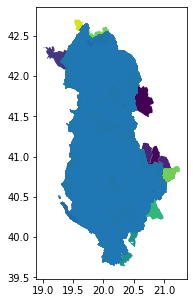

In [176]:
import matplotlib.pyplot as plt
### test that the spatial join worked
n=6
wd_list = list(gwd[gwd['MOL_IDg']==n].MOL_ID.unique())
fig, ax = plt.subplots(figsize=(5, 5))
wd[wd['MOL_ID'].isin(wd_list)].plot(ax=ax, column='MOL_ID')
gwd[gwd['MOL_IDg']==n].plot(ax=ax,alpha=0.1)

In [177]:
item = gis.content.get('e9b2595e8ee2406b981fd7c00f77df9c')
flayer = item.layers[0]
sdf = pd.DataFrame.spatial.from_layer(flayer)

In [178]:
gadm0.rename(columns={'WDPA_MOL_ID':'wdpa_mol_id'},inplace=True)

In [180]:
fields_to_be_added = createFieldsToBeAdded(flayer, csv_table= gadm0[['MOL_ID','wdpa_mol_id']])

In [181]:
fields_to_be_added

[{'name': 'wdpa_mol_id',
  'type': 'esriFieldTypeString',
  'actualType': 'nvarchar',
  'alias': 'wdpa_mol_id',
  'sqlType': 'sqlTypeOther',
  'length': 45000,
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None}]

In [182]:
flayer.manager.add_to_definition({'fields':fields_to_be_added})

{'success': True}

In [188]:
start = np.arange(0,len(gadm0), step = 25)
start

array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250])

In [190]:
# Broken Pipe, the connection times out so it has to be broken down to less updates (chunks of 100)
for i in start:
    features_for_update = createFeaturesForUpdate(flayer,  
                                              gadm0[['MOL_ID','wdpa_mol_id']][i:i+25], 
                                              fields_to_be_added, 
                                              id_field_in_csv = "MOL_ID", 
                                              id_field_in_service = "MOL_ID")
    flayer.edit_features(updates= features_for_update)
    print(f'done {i}')
    

done 0
done 25
done 50
done 75
done 100
done 125
done 150
done 175
done 200
done 225
done 250


## WDPA data <a class="anchor" id="third-bullet"></a>

In [78]:
### gadm tables
## Original scott table (https://eowilson.maps.arcgis.com/home/item.html?id=ba1e71b5d83548808ee02d1108221cae)
scott= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.zip')

## Simplified wdpa table
### Topojson, tolerance 0.05
simple = gpd.read_file('/Users/tamarahuete/Documents/HALF_EARTH/wdpa_simple_topojson.shp')

### gadm as raster area (from Scott's table)
#gadmpix = pd.read_csv('../../HALF_EARTH/gadm1_polygon_to_raster.csv')

#### - (WDPA) Format Biodiversity data

In [82]:
### Use here simple gadm0 
dff = scott[['NAME','MOL_ID','AREA_KM']] ## remove geometry here because it is the non-simplified table
dff = dff.rename(columns={'AREA_KM':'AREA_KM2'})
dff['reptiles']=np.nan
dff['amphibians']=np.nan
dff['mammals']=np.nan
dff['birds']=np.nan

paths = {'amphibians':'../../HALF_EARTH/wdpa_amphibians_sample_20211003_nozeros.zip',
         'birds':'../../HALF_EARTH/wdpa_birds_final_20211003.csv',
         'mammals':'../../HALF_EARTH/wdpa_mammals_final_20211003.csv',
         'reptiles':'../../HALF_EARTH/wdpa_reptiles_final_20211003.zip'}

### Ids of lookup tables for each taxa in ArcGIS online
lookups = {'amphibians':'a641a4cd269345dea93b8bcb1cb66676',
         'birds':'4d8698734b654bb9bb7a61d9af314c76',
         'mammals':'84d3c71caf97479d85f620a4ee217d68',
         'reptiles':'b720e84869624e5482b25338b27a54f2'}

In [ ]:
### WARNING: THIS PROCESS TOOK FOREVER (OVER A WEEK WITH DISTRIBUTED NOTEBOOKS)
### CONSIDER USING PANDARALLEL OR OTHER PARALLEL PROCESSING APPROACH IF THIS NEEDS TO BE REPEATED
%%time
### Loop over each set of data and add all results to one dictionary that will be a text field in the Feature Service
for taxa in paths.keys():
    print(taxa) 
    df = pd.read_csv(paths[taxa])
    col_name = [col for col in df.columns if col in ['amphibians','birds','presence','reptiles']]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)
    df = df.merge(scott[['MOL_ID','AREA_KM2']])
    df['percentage_presence'] = round(df['SUM']/df['AREA_KM2']*100,2)
    df.loc[df['percentage_presence']> 100,'percentage_presence'] = 100
    for i in dff.MOL_ID:
        species = []
        for j in df[(df.MOL_ID== i)].SliceNumber.unique():
            sp_dict = {'SliceNumber':df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0].astype(float),
                       'percentage_presence':df[(df.MOL_ID== i) & (df.SliceNumber==j)].percentage_presence.values[0]}
            species.append(sp_dict)
        dff.loc[dff['MOL_ID']==i,taxa] =json.dumps(species)
        print(f'finished MOL_ID ={i}')
pd.set_option('display.max_colwidth',None)
test= pd.DataFrame(dff[dff.columns[~dff.columns.isin(['geometry'])]])
test.to_csv("../../HALF_EARTH/wdpa_precalc_biodiv.csv",index=False)
pd.reset_option('display.max_colwidth')

#### Don't export as shapefile because it truncates the string length

In [ ]:
PARALLELIZE OPTION: See Nootebok: 

### Aggregate in a single file

In [2]:
files={'reptiles':['wdpa_precalc_biodiv_range_reptiles_1.csv',
                   'wdpa_precalc_biodiv_range_reptiles_2.csv'],
       'mammals':['wdpa_precalc_biodiv_range_mammals_1.csv',
                  'wdpa_precalc_biodiv_range_mammals_2.csv',
                  'wdpa_precalc_biodiv_range_mammals_3.csv',
                 'wdpa_precalc_biodiv_range_mammals_4.csv'],
       'birds':['wdpa_precalc_biodiv_range_birds_1.csv',
                'wdpa_precalc_biodiv_range_birds_2.csv'],
      'amphibians':['wdpa_precalc_biodiv_range_amphibians_2.csv',
                   'wdpa_precalc_biodiv_range_amphibians_3.csv',
                   'wdpa_precalc_biodiv_range_amphibians_4.csv']}

In [3]:
path = '../../HALF_EARTH/'
amph= pd.read_csv(f'{path}wdpa_precalc_biodiv_range_amphibians_1.csv')

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
amph.head()

,NAME,MOL_ID,AREA_KM2,reptiles,amphibians,mammals,birds
0,Boulder Beach,1,1.136031,NaN,[],NaN,NaN
1,Ferndale,2,0.748492,NaN,"[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...",NaN,NaN
2,Broughton Bay,3,0.031907,NaN,"[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...",NaN,NaN
3,Kaipupu Point,4,0.270855,NaN,"[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...",NaN,NaN
4,Catlins Conservation Park,5,8.412168,NaN,"[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...",NaN,NaN


In [6]:
mam = pd.read_csv(f'{path}wdpa_precalc_biodiv_range_mammals_4.csv')

In [8]:
mam.tail()

,NAME,MOL_ID,AREA_KM2,reptiles,amphibians,mammals,birds
54366,Marine Reserve,217478.0,0.0,NaN,NaN,[],NaN
54367,Marine Reserve,217479.0,0.0,NaN,NaN,[],NaN
54368,Gata Fish Sanctuary,217480.0,0.0,NaN,NaN,[],NaN
54369,Kabunwangan-Kinapsagan Fish Sanctuary,217481.0,0.0,NaN,NaN,[],NaN
54370,Sablayan Fish Sanctuary,217482.0,0.0,NaN,NaN,[],NaN


In [11]:
### Paste al together based on one of the files
path = '../../HALF_EARTH/'
amph= pd.read_csv(f'{path}wdpa_precalc_biodiv_range_amphibians_1.csv')
amph.replace({'[]':np.nan},inplace=True)
for taxa in files:
    missing = amph[amph[taxa].isnull()].index.tolist()
    print(f'there are {len(missing)} missing {taxa}')
    for i in range(0,len(files[taxa])):
        try:
            df = pd.read_csv(path+files[taxa][i])
        except:
            continue 
        df.dropna(subset=[taxa],inplace=True)
        m = df.set_index('MOL_ID')[taxa]
        amph.loc[amph['MOL_ID'].isin(df['MOL_ID']),taxa] =amph['MOL_ID'].map(m)
    
    missing = amph[amph[taxa].isnull()].index.tolist()
    print(f'after joins, there are {len(missing)} missing {taxa}')
## replace '[]' in amphibians
amph.replace({'amphibians':{np.nan:'[]'}},inplace=True) 

there are 217486 missing reptiles
after joins, there are 0 missing reptiles
there are 217486 missing mammals
after joins, there are 0 missing mammals
there are 217486 missing birds
after joins, there are 217486 missing birds
there are 152486 missing amphibians
after joins, there are 0 missing amphibians


In [90]:
amph.head()

,NAME,MOL_ID,AREA_KM2,reptiles,amphibians,mammals,birds
0,Boulder Beach,1,1.136031,[],[],"[{""SliceNumber"": 303, ""per_global"": 0.0, ""per_...",NaN
1,Ferndale,2,0.748492,"[{""SliceNumber"": 6163, ""per_global"": 0.0, ""per...","[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...","[{""SliceNumber"": 303, ""per_global"": 0.0, ""per_...",NaN
2,Broughton Bay,3,0.031907,"[{""SliceNumber"": 6499, ""per_global"": 0.0, ""per...","[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...","[{""SliceNumber"": 303, ""per_global"": 0.0, ""per_...",NaN
3,Kaipupu Point,4,0.270855,"[{""SliceNumber"": 6163, ""per_global"": 0.0, ""per...","[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...","[{""SliceNumber"": 303, ""per_global"": 0.0, ""per_...",NaN
4,Catlins Conservation Park,5,8.412168,"[{""SliceNumber"": 6163, ""per_global"": 0.01, ""pe...","[{""SliceNumber"": 3318, ""per_global"": 0.0, ""per...",[],NaN


In [12]:
amph.to_csv("../../HALF_EARTH/wdpa_precalc_biodiv_range_area_NOBIRDS.csv")

### Combine biodiversity and simplified geometries

In [246]:
len(scott)-len(simple) ### 297 records missing from the original layer (removed records with no geoemtries)

297

In [251]:
simple.head()

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NA,DESIG,DESIG_E,DESIG_T,IUCN_CA,INT_CRI,...,ISO3,SUPP_IN,CONS_OB,SORTER,WDPA_PID_h,WDPA_PID__,hash_vl,AREA_KM,MOL_ID,geometry
0,555622117.0,555622117,1,Centre Hills,Centre Hills,Protected Forest,Protected Forest,National,VI,Not Applicable,...,MSR,Not Applicable,Not Applicable,0.0,77a6c0f9,1185435043,1185435043,11.119859,194938,"POLYGON ((-62.17871 16.76841, -62.18096 16.745..."
1,643.0,643,1,Odzala Kokoua,Odzala Kokoua,Parc National,National Park,National,II,Not Applicable,...,COG,Not Applicable,Not Applicable,0.0,2fb5e85a,-719853802,-719853802,13603.549516,32844,"POLYGON ((15.34540 0.69102, 15.34984 0.47770, ..."
2,354009.0,354009,1,Patte d'Oie,Patte d'Oie,Réserve de Forêt,Forest Reserve,National,Not Reported,Not Applicable,...,COG,Not Applicable,Not Applicable,0.0,b6af608f,-475696095,-475696095,0.832384,33448,"MULTIPOLYGON (((15.25375 -4.26892, 15.25377 -4..."
3,2266.0,2266,1,Léfini,Léfini,Réserve de Faune,Wildlife Reserve,National,IV,Not Applicable,...,COG,Not Applicable,Not Applicable,0.0,6c9f9cb6,687565067,687565067,3497.795378,35527,"POLYGON ((15.52455 -3.07424, 15.52451 -3.07401..."
4,555571316.0,555571316,1,Mont Mavoumbou,Mont Mavoumbou,Domaine de Chasse,Hunting Area,National,Not Reported,Not Applicable,...,COG,Not Applicable,Not Applicable,0.0,9a2dc388,-1335579272,-1335579272,228.702786,37298,"POLYGON ((11.74125 -2.77998, 11.85915 -2.88393..."


In [254]:
simple.columns

Index(['WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NA', 'DESIG', 'DESIG_E',
       'DESIG_T', 'IUCN_CA', 'INT_CRI', 'MARINE', 'REP_M_A', 'GIS_M_A',
       'REP_ARE', 'GIS_ARE', 'NO_TAKE', 'NO_TK_A', 'STATUS', 'STATUS_',
       'GOV_TYP', 'OWN_TYP', 'MANG_AU', 'MANG_PL', 'VERIF', 'METADAT',
       'SUB_LOC', 'PARENT_', 'ISO3', 'SUPP_IN', 'CONS_OB', 'SORTER',
       'WDPA_PID_h', 'WDPA_PID__', 'hash_vl', 'AREA_KM', 'MOL_ID', 'geometry'],
      dtype='object')

In [256]:
simple_biodiv =dff.merge(simple[['MOL_ID','geometry','DESIG','DESIG_E','IUCN_CA','ISO3','WDPA_PID','AREA_KM']],on ='MOL_ID',how='right')

In [257]:
len(simple_biodiv)

217189

In [258]:
simple_biodiv.head()

,NAME,MOL_ID,reptiles,amphibians,mammals,birds,geometry,DESIG,DESIG_E,IUCN_CA,ISO3,WDPA_PID,AREA_KM
0,Boulder Beach,1,[],[],"[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 482.0, ""percentage_presence"":...","MULTIPOLYGON (((170.62746 -45.89520, 170.63025...",Stewardship Area,Stewardship Area,III,NZL,310492,1.136031
1,Ferndale,2,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 0...","POLYGON ((173.97642 -41.19258, 173.96741 -41.1...",Scenic Reserve,Scenic Reserve,III,NZL,307797,0.748492
2,Broughton Bay,3,"[{""SliceNumber"": 6499.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 1847.0, ""percentage_presence""...","POLYGON ((173.95691 -41.20976, 173.95513 -41.2...",Scenic Reserve,Scenic Reserve,III,NZL,307745,0.031907
3,Kaipupu Point,4,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 1...","POLYGON ((174.00241 -41.27336, 174.00885 -41.2...",Scenic Reserve,Scenic Reserve,III,NZL,307867,0.270855
4,Catlins Conservation Park,5,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...",[],"[{""SliceNumber"": 8.0, ""percentage_presence"": 1...","MULTIPOLYGON (((169.30645 -46.57949, 169.30754...",Stewardship Area,Stewardship Area,III,NZL,303963,8.412168


In [262]:
### Save full version as geojson
gdf = gpd.GeoDataFrame(simple_biodiv, geometry=simple_biodiv.geometry)
gdf.to_file('../../HALF_EARTH/biodiv_precalc_wdpa.geojson',driver='GeoJSON') ## 380 MB and the limit is 100 MB

### Merge with contextual precalculated data

In [230]:
elu = pd.read_csv("../../HALF_EARTH/ZonalSt_Majority_ELU.csv")
elu_lookup= pd.read_csv("../../HALF_EARTH/ecosytem_categories_lookup.zip")
pop = pd.read_csv("../../HALF_EARTH/ZonalSt_sum_pop.csv")
le = pd.read_csv("../../HALF_EARTH/ZonalStat_LE_MOLID.csv")

In [215]:
### POPULATION
pop.rename(columns={'SUM':'population_sum'},inplace=True)
dff = dff.merge(pop[['MOL_ID','population_sum']],how='left',on='MOL_ID')
dff.head()

,NAME,MOL_ID,AREA_KM,reptiles,amphibians,mammals,birds,population_sum
0,Boulder Beach,1,1.136031,[],[],"[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 482.0, ""percentage_presence"":...",2.110001
1,Ferndale,2,0.748492,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",1.315837
2,Broughton Bay,3,0.031907,"[{""SliceNumber"": 6499.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 1847.0, ""percentage_presence""...",NaN
3,Kaipupu Point,4,0.270855,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",NaN
4,Catlins Conservation Park,5,8.412168,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...",[],"[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",3.103363


In [216]:
### Ecosystem lan units
dff = dff.merge(elu[['MOL_ID','MAJORITY']],how='left',on='MOL_ID')
dff.rename(columns={'MAJORITY':'majority_land_cover_climate_regime'},inplace=True)
dff.head()

,NAME,MOL_ID,AREA_KM,reptiles,amphibians,mammals,birds,population_sum,majority_land_cover_climate_regime
0,Boulder Beach,1,1.136031,[],[],"[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 482.0, ""percentage_presence"":...",2.110001,107.0
1,Ferndale,2,0.748492,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",1.315837,176.0
2,Broughton Bay,3,0.031907,"[{""SliceNumber"": 6499.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 1847.0, ""percentage_presence""...",NaN,NaN
3,Kaipupu Point,4,0.270855,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",NaN,NaN
4,Catlins Conservation Park,5,8.412168,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...",[],"[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",3.103363,97.0


In [218]:
elu_lookup= pd.read_csv("../../HALF_EARTH/ecosytem_categories_lookup.zip")

In [219]:
elu_lookup

,elu_code,elu,lc_type,lf_type,cr_type,ObjectId
0,301,Sub Tropical Moist Forest on Plains,Forest,Plains,Sub Tropical Moist,1
1,201,Warm Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Warm Temperate Dry,2
2,151,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Cool Temperate Dry,3
3,302,Sub Tropical Moist Cropland on Tablelands,Cropland,Tablelands,Sub Tropical Moist,4
4,152,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Tablelands,Cool Temperate Dry,5
...,...,...,...,...,...,...
426,427,Polar Desert Forest on Plains,Forest,Plains,Polar Desert,427
427,428,Polar Desert Settlement on Mountains,Settlement,Mountains,Polar Desert,428
428,429,Warm Temperate Desert Forest on Tablelands,Forest,Tablelands,Warm Temperate Desert,429
429,430,Polar Desert Grassland on Tablelands,Grassland,Tablelands,Polar Desert,430


In [222]:
lc = dict(zip(elu_lookup['elu_code'],elu_lookup['lc_type']))
cr = dict(zip(elu_lookup['elu_code'],elu_lookup['cr_type']))

In [223]:
dff['land_cover_majority']=dff['majority_land_cover_climate_regime']
dff['climate_regime_majority']=dff['majority_land_cover_climate_regime']

In [224]:
dff.replace({'land_cover_majority':lc,'climate_regime_majority':cr},inplace=True)

In [232]:
le.head()

,OID_,MOL_ID,COUNT,AREA,SliceNumber,MEAN,SUM,Total,percentage_land_encroachment
0,1,139,3.0,0.000208,1.0,0.256359,0.769076,NaN,NaN
1,2,258,10.0,0.000694,1.0,0.573516,5.735156,410.0,2.44
2,3,269,254.0,0.017639,1.0,0.294000,74.676078,5687.0,4.47
3,4,576,44.0,0.003055,1.0,0.650556,28.624443,240.0,18.33
4,5,577,2.0,0.000139,1.0,0.652536,1.305072,129.0,1.55


In [241]:
le_wide =le.pivot(index='MOL_ID', columns='SliceNumber', values='percentage_land_encroachment').reset_index()

In [243]:
dff = dff.merge(le_wide[['MOL_ID',1,2,3,4]],how='left',on='MOL_ID')
dff.rename(columns={1.0:'percent_irrigated',2.0:'percent_rainfed',3.0:'percent_rangeland',4.0:'percent_urban'},inplace=True)
dff.head()

,NAME,MOL_ID,AREA_KM,reptiles,amphibians,mammals,birds,population_sum,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban
0,Boulder Beach,1,1.136031,[],[],"[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 482.0, ""percentage_presence"":...",2.110001,107.0,Grassland,Cool Temperate Moist,NaN,NaN,100.00,NaN
1,Ferndale,2,0.748492,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",1.315837,176.0,Forest,Warm Temperate Moist,NaN,NaN,NaN,NaN
2,Broughton Bay,3,0.031907,"[{""SliceNumber"": 6499.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 1847.0, ""percentage_presence""...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Kaipupu Point,4,0.270855,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...","[{""SliceNumber"": 303.0, ""percentage_presence"":...","[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN
4,Catlins Conservation Park,5,8.412168,"[{""SliceNumber"": 6163.0, ""percentage_presence""...","[{""SliceNumber"": 3318.0, ""percentage_presence""...",[],"[{""SliceNumber"": 8.0, ""percentage_presence"": 1...",3.103363,97.0,Forest,Cool Temperate Moist,NaN,NaN,71.43,NaN


In [ ]:
### Greta's precalculated data
precalc = pd.read_csv("../../HALF_EARTH/wdpa_precalculated_data.zip")
len(precalc) #66653 (of 217486)

### Add WDPA data

In [246]:
len(simple)

217189

In [248]:
len(scott)

217486

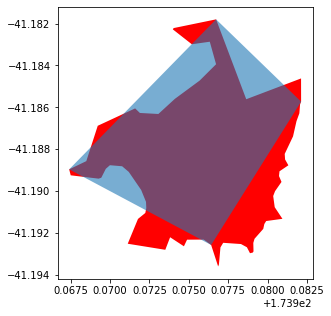

In [260]:
### check simplified geometries
n = 2
fig, ax = plt.subplots(figsize=(5, 5))
scott.loc[scott['MOL_ID']==n,'geometry'].plot(ax=ax,color='red')
simple.loc[simple['MOL_ID']==n,'geometry'].plot(ax=ax,alpha=0.6)

In [262]:
### Add the simplified geometries to scott's table. if the simplified geometry does not exist, keep the previous non simplified one
m = simple.set_index('MOL_ID')['geometry']
scott.loc[scott['MOL_ID'].isin(simple['MOL_ID']),'geometry'] =scott['MOL_ID'].map(m)

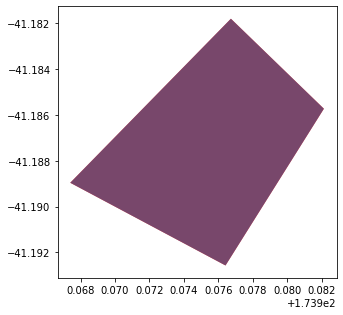

In [263]:
n = 2
fig, ax = plt.subplots(figsize=(5, 5))
scott.loc[scott['MOL_ID']==n,'geometry'].plot(ax=ax,color='red')
simple.loc[simple['MOL_ID']==n,'geometry'].plot(ax=ax,alpha=0.6)

In [264]:
len(scott)

217486

In [269]:
### Join dff_merge with wdpa data
all_data = dff.merge(scott[['WDPAID', 'DESIG','DESIG_E','DESIG_T','IUCN_CA','ISO3','MOL_ID','geometry']],on ='MOL_ID',how='left')

In [270]:
len(all_data)

217486

In [271]:
all_data.columns

Index(['NAME', 'MOL_ID', 'AREA_KM', 'reptiles', 'amphibians', 'mammals',
       'birds', 'population_sum', 'majority_land_cover_climate_regime',
       'land_cover_majority', 'climate_regime_majority', 'percent_irrigated',
       'percent_rainfed', 'percent_rangeland', 'percent_urban', 'WDPAID',
       'DESIG', 'DESIG_E', 'DESIG_T', 'IUCN_CA', 'ISO3', 'geometry'],
      dtype='object')

In [277]:
## Save datasets
#gdf = gpd.GeoDataFrame(all_data, geometry=all_data.geometry)
#gdf = gdf.set_crs('EPSG:4326')
gdf.to_file('../../HALF_EARTH/all_precalc_wdpa.geojson',driver='GeoJSON') ### full data + geometry
gdf[['MOL_ID','geometry']].to_file('../../HALF_EARTH/all_precalc_wdpa_only_geom.shp') ### only geometries
#all_data[all_data.columns[~all_data.columns.isin(['geometry'])]].to_csv('../../HALF_EARTH/all_precalc_wdpa_no_geom.csv') ## only data

In [276]:
gdf = gdf.set_crs('EPSG:4326')

### WDPA no simplification

In [ ]:
wdpa= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.zip')

In [ ]:
### Save zip of original file with less fields
wdpa = scott[['WDPAID','MOL_ID','NAME','ORIG_NA','GOV_TYP','DESIG','DESIG_E','STATUS','DESIG_T','IUCN_CA','ISO3','AREA_KM','geometry']]
with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir = Path(temp_dir)
    localFile = '../../HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields'
    
    wdpa.to_file(filename=temp_dir, driver='ESRI Shapefile')
    archiveFile = shutil.make_archive(localFile, 'zip', temp_dir)
    #shutil.rmtree(temp_dir) ### failed

In [67]:
### Add shapefile of original wdpa
csv_file = '../../HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields.zip'
csvName = 'WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields'
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")
aol_folder_name = '#6 precalculated data'
group_id='46783c33c294485abe83f5e899c2f21f'
publishCSVasFS(csv_file,csvName,gis,aol_folder_name,sharing='everyone', table = 'no')

Service name WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields is available
The service WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields has been published. The service has 217486 entries
Moving service WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields to #6 precalculated data in ArcGIS Online...
Service WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields has been moved to #6 precalculated data in ArcGIS Online
shared with everyone
WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa_selected_fields's protection against deletion : True


'f3b235ccb45a4cbcad9c4d5cbfb34655'

## Final data upload:
* Upload everything as geojson failed.
* Shapefile with MOLID + geometries: [FS](https://eowilson.maps.arcgis.com/home/item.html?id=bc3ec13b468d4f2484e1059933dcbe32)/ [URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/all_precalc_wdpa_only_geom/FeatureServer)/[Whitelisted URL](https://utility.arcgis.com/usrsvcs/servers/d6dd590bd6734f90a626a1dc156f4546/rest/services/all_precalc_wdpa_only_geom/FeatureServer)
* Hosted table with all precalculated data [FS](https://eowilson.maps.arcgis.com/home/item.html?id=00520b68c2af41d39a3dfec82a27ebf6)/ [URL](https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/all_precalc_wdpa_no_geom/FeatureServer)/[Whitelisted URL](https://utility.arcgis.com/usrsvcs/servers/051ba1f3714748bfb4c725d29b938e20/rest/services/all_precalc_wdpa_no_geom/FeatureServer)   
    

In [5]:
### Upload a table with WDPA geometries and information

In [6]:
gdf = gpd.read_file('../../HALF_EARTH/all_precalc_wdpa.geojson') ### context data + geometry

In [7]:
len(gdf)

217486

In [59]:
scott = gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.zip')

In [68]:
scott.columns

Index(['WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NA', 'DESIG', 'DESIG_E',
       'DESIG_T', 'IUCN_CA', 'INT_CRI', 'MARINE', 'REP_M_A', 'GIS_M_A',
       'REP_ARE', 'GIS_ARE', 'NO_TAKE', 'NO_TK_A', 'STATUS', 'STATUS_',
       'GOV_TYP', 'OWN_TYP', 'MANG_AU', 'MANG_PL', 'VERIF', 'METADAT',
       'SUB_LOC', 'PARENT_', 'ISO3', 'SUPP_IN', 'CONS_OB', 'SORTER',
       'WDPA_PID_h', 'WDPA_PID__', 'hash_vl', 'AREA_KM', 'MOL_ID', 'geometry'],
      dtype='object')

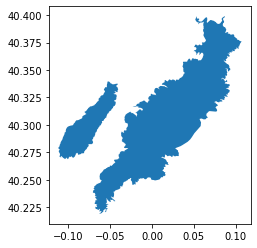

In [69]:
scott[scott['MOL_ID']==211877.0].plot()

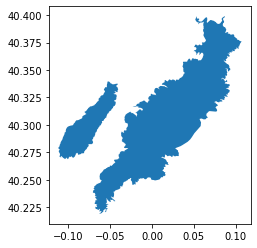

In [70]:
wdpa[wdpa['MOL_ID']==211877.0].plot()

In [10]:
gdf = gdf.merge(scott[['ORIG_NA','GOV_TYP','MOL_ID']], on ='MOL_ID')

### Update the fields in the existing feature service with python API

In [12]:
update_csv = gdf[['WDPAID','MOL_ID','NAME','ORIG_NA','GOV_TYP','DESIG','DESIG_E','DESIG_T','IUCN_CA','ISO3','AREA_KM','geometry']]

In [13]:
item = gis.content.get('bc3ec13b468d4f2484e1059933dcbe32')
flayer = item.layers[0]
#sdf = pd.DataFrame.spatial.from_layer(flayer)

#### Create new fields on FS and update with the values of the new dataframe

In [17]:
## Create fields
def createFieldsToBeAdded(flayer, csv_table):
    flayer_fields = flayer.manager.properties.fields
    template_field = dict(deepcopy(flayer_fields[0]))
    sdf = getSDFfromFlayer(flayer)
    new_field_names = list(csv_table.columns.difference(sdf.columns))
    
    fields_to_be_added = []
    for new_field_name in new_field_names:
        current_field = deepcopy(template_field)
        dt = csv_table[new_field_name].dtypes
        
        if dt == 'O':
            #put the type to character
            current_field['sqlType'] = 'sqlTypeOther'
            current_field['type'] = 'esriFieldTypeString'
            current_field['length'] = 45000
        if dt == 'float64':
            #put the type to double
            current_field['sqlType'] = 'sqlTypeOther'
            current_field['type'] = 'esriFieldTypeDouble'
            #current_field['length'] = 8000      

        current_field['name'] = new_field_name
        current_field['alias'] = new_field_name
        current_field['nullable'] = True
        current_field['editable'] = True
        fields_to_be_added.append(current_field)
    return fields_to_be_added

In [19]:
fields_to_be_added = createFieldsToBeAdded(flayer, csv_table= update_csv)

In [34]:
fields_to_be_added

[{'name': 'AREA_KM',
  'type': 'esriFieldTypeDouble',
  'actualType': 'int',
  'alias': 'AREA_KM',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None},
 {'name': 'DESIG',
  'type': 'esriFieldTypeString',
  'actualType': 'int',
  'alias': 'DESIG',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None,
  'length': 45000},
 {'name': 'DESIG_E',
  'type': 'esriFieldTypeString',
  'actualType': 'int',
  'alias': 'DESIG_E',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None,
  'length': 45000},
 {'name': 'DESIG_T',
  'type': 'esriFieldTypeString',
  'actualType': 'int',
  'alias': 'DESIG_T',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None,
  'length': 45000},
 {'name': 'GOV_TYP',
  'typ

In [43]:
### In case I need to retrieve the fields
import json
with open('fields_to_be_added.txt', 'w') as outfile:
    json.dump(fields_to_be_added, outfile)

In [44]:
with open('fields_to_be_added.txt') as json_file:
    fields_to_be_added = json.load(json_file)

In [45]:
fields_to_be_added

[{'name': 'AREA_KM',
  'type': 'esriFieldTypeDouble',
  'actualType': 'int',
  'alias': 'AREA_KM',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None},
 {'name': 'DESIG',
  'type': 'esriFieldTypeString',
  'actualType': 'int',
  'alias': 'DESIG',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None,
  'length': 45000},
 {'name': 'DESIG_E',
  'type': 'esriFieldTypeString',
  'actualType': 'int',
  'alias': 'DESIG_E',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None,
  'length': 45000},
 {'name': 'DESIG_T',
  'type': 'esriFieldTypeString',
  'actualType': 'int',
  'alias': 'DESIG_T',
  'sqlType': 'sqlTypeOther',
  'nullable': True,
  'editable': True,
  'visible': True,
  'domain': None,
  'defaultValue': None,
  'length': 45000},
 {'name': 'GOV_TYP',
  'typ

In [21]:
flayer.manager.add_to_definition({'fields':fields_to_be_added})

{'success': True}

In [46]:
#https://developers.arcgis.com/python/sample-notebooks/updating-features-in-a-feature-layer/
def createFeaturesForUpdate(flayer, csv_table, fields_to_be_added, id_field_in_csv, id_field_in_service):  
    features_for_update = []
    for country_id in csv_table[id_field_in_csv]:
        try:
            # get the matching row from csv
            matching_row = csv_table.where(csv_table[id_field_in_csv] == country_id).dropna()

            #print(str(country_id) + " Adding additional attributes for: " + matching_row['iso3'].values[0])

            # get the feature to be updated
            assert  len([f for f in features2 if f.attributes[id_field_in_service] == country_id]), "id not matched"
            original_feature = [f for f in features2 if f.attributes[id_field_in_service] == country_id][0]
            feature_to_be_updated = deepcopy(original_feature)

            # assign the updated values
            for field in fields_to_be_added:
                feature_to_be_updated.attributes[field['name']] = matching_row[field['name']].values[0]
                #add this to the list of features to be updated
                features_for_update.append(feature_to_be_updated)
    
        except:
            print(f"{country_id} not available in service")
    return features_for_update

In [47]:
#### Updates must be done in blocks to avoid broken pipe of ARcGIS API
#start = np.arange(2,217486, step = 100)
start = np.arange(45002,217486, step = 100)
start

array([ 45002,  45102,  45202, ..., 217202, 217302, 217402])

In [ ]:
fset2 = flayer.query()
features2 = fset2.features
for i in start:
    features_for_update = createFeaturesForUpdate(flayer,  
                                              update_csv[i:i+100], 
                                              fields_to_be_added, 
                                              id_field_in_csv = "MOL_ID", 
                                              id_field_in_service = "MOL_ID")
    for attempt in range(10):
        try:
            flayer.edit_features(updates= features_for_update)
        except Exception:
            print(f'Timeout #{attempt}')
            pass
    print(f'done {i}')

done 45002
Timeout #7
done 45102
done 45202
done 45302
Timeout #9
done 45402
done 45502
Timeout #1
done 45602
done 45702
done 45802
done 45902
Timeout #0
done 46002
done 46102
done 46202
done 46302
done 46402
Timeout #4
done 46502
Timeout #1
done 46602
Timeout #9
done 46702
done 46802
Timeout #0
done 46902
Timeout #1
done 47002
done 47102
done 47202
done 47302
done 47402
done 47502
done 47602
Timeout #0
done 47702
done 47802
done 47902
done 48002
done 48102
done 48202
done 48302
Timeout #0
done 48402
done 48502
done 48602
Timeout #0
done 48702
Timeout #5
done 48802
done 48902
done 49002
Timeout #1
done 49102
Timeout #2
Timeout #3
done 49202
Timeout #0
done 49302
done 49402
done 49502
done 49602
Timeout #6
Timeout #9
done 49702
done 49802
Timeout #4
done 49902
done 50002
Timeout #5
Timeout #6
Timeout #7
Timeout #8
Timeout #9
done 50102
50203 not available in service
50204 not available in service
50205 not available in service
50206 not available in service
50207 not available in servic

In [ ]:
for _ in range(max_retries):
    try:
        do something
        break
    except TimeoutError:
        pass